In [1]:
import sys
import os
import matplotlib.pyplot as plt
% matplotlib inline
import pickle
# Import class
parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
class_dir = os.path.join(parent_dir, 'Scripts')
sys.path.insert(0, class_dir)
import NBAStats
import numpy as np
import datetime as dt
import pandas as pd
stats_file = os.path.join(parent_dir, 'Data', 'nba_stats.pickle')
print(stats_file)
nba_stats = pickle.load(open(stats_file, 'rb'))

C:\Users\johnn\Desktop\github\nba_stats\Data\nba_stats.pickle


In [2]:
def get_player_df(nba_stats, player, player_id=False):
    ''' Get the dataframe containing info on referenced player. If player_id=True, player id given instead of name'''
    if player_id:
        if player not in nba_stats.get_player_stats().keys():
            raise ValueError('player_id {} not found'.format(player))
        
        return nba_stats.get_player_stats()[player].sort_index(ascending=False)
    else:
        if player not in nba_stats.get_player_name_id_dict().keys():
            raise ValueError('player name {} not found'.format(player))
        
        return nba_stats.get_player_stats()[nba_stats.get_player_name_id_dict()[player]].sort_index(ascending=False)

In [3]:
def player_df_convert_numeric(player_df):
    ''' Returns a dataframe that converts relevant columns to numeric 
    Columns converted:
    MIN
    '''
    player_df['MIN'] = player_df['MIN'].apply(
        lambda str_min: int(str_min[:-3]) + int(str_min[-2:])/60.0 if str_min is not None else 0 )

    return player_df

# Motivation

Bet on the spread between the team's winning odds and the player points odds. If we can find a significant relationship between how much a player scores and the result of the game, we can capture deviations from the implied probabilities. Suppose in the case below, it seems like the probability that James Harden scores more than 25.5 points is significantly higher for wins that for losses.

Using this, we can work out our theo probability based off the game's implied probability. We can then either back the player and lay the team or vice versa (assuming there is a positive relationship). Although this probability can be reversed (working out team's odds based on player's odds), the spread for the team odds would be much tighter, and with more turnover, it is likely to be more accurate.

Suppose we back the player and lay the team. What we are essentially betting on is either the team is overpriced or the player is underpriced. More likely than not, the player is underpriced. The worst case scenario here is that the team wins and the player doesn't score the baseline.

## Use
From what I've seen, there doesn't seem to be a very active market in the player points market. So I might try to use this as a market making tool.

In [8]:
def pl_pts_odds_WL(player_name, stat, baseline, past_n_games, opp_team=None):

    player_df = get_player_df(nba_stats, player_name)
    player_df = player_df_convert_numeric(player_df)
    player_df_played = player_df[player_df.MIN > 0]
    player_df_recent = player_df_played.head(past_n_games)

    # Remove any duplicates (don't know why there are duplicates)
    # UPDATE: Shouldn't be any more duplicates due to fixing issue #2
#     player_df_recent = player_df_recent[~player_df_past_100_wl.duplicated()]
    assert player_df_recent.duplicated().sum() == 0
    
    ## Create figure
    fig, ax = plt.subplots(2, 2, figsize=(20, 10))

    ############## PLOT 100 EMPIRICAL
    n_overs = (player_df_recent[stat] > baseline).sum()
    n = len(player_df_recent)
    player_df_recent[stat].plot(kind='hist', ax=ax[0, 0])
    ax[0, 0].axvline(x=baseline, color='black')
    pr_over_baseline = n_overs/float(n)

    ax[0, 0].set_title('Based on past 100 games empirical\nCan back over at {:.2f} and unders at {:.2f}'.format(1/pr_over_baseline,
                                                                                                1/(1-pr_over_baseline)))

    ############## PLOT stat time series
    player_df_played.plot(y=stat, drawstyle='steps-post', ax=ax[1, 1])
    ax[1, 1].axhline(y=baseline, color='black')
    ax[1, 1].axvline(x=player_df_recent.index.min(), color='red')
    ax[1,1].set_title('All games')

    ############## PLOT stat time series recent
    df_player_teams = player_df_recent[['TEAM_ABBREVIATION']].drop_duplicates('TEAM_ABBREVIATION', keep='last')

    player_df_recent.plot(y=stat, drawstyle='steps-post', ax=ax[0, 1])
    ax[0,1].axhline(y=baseline, color='black')
    ax[0,1].set_title('Past {} games'.format(past_n_games))
    
    # Plot different teams the player has played for
    for i, row in df_player_teams.iterrows():
        ax[0, 1].axvline(x=row.name, color='red', linestyle='dashed')
        ax[0, 1].text(x=row.name+dt.timedelta(2), y=0, s=row.TEAM_ABBREVIATION, color='red')
    
    # Plot points of player's previous games against this opponent
    
    ############## Get player's statistics from last game against opponent
    if opp_team is not None:
        df_opp_team = pd.DataFrame(player_df_played[player_df_played['OPP_TEAM_ABBREVIATION'] == opp_team])
        if len(df_opp_team) > 0:
            # Plot points on recent games
            ax[0,1].scatter(df_opp_team.index, df_opp_team[stat], color='red', 
                        marker='x', s=120)
            
            # Plot all previous games with opp
            ax[1,0].plot(df_opp_team.index, df_opp_team[stat],
                        drawstyle='steps-post', color='red')
            ax[1,0].set_title('All previous games against {}'.format(opp_team))
            ax[1,0].axhline(y=baseline, color='black')
            ax[1,0].set_ylim(ymin=0)
            
    return player_df_recent

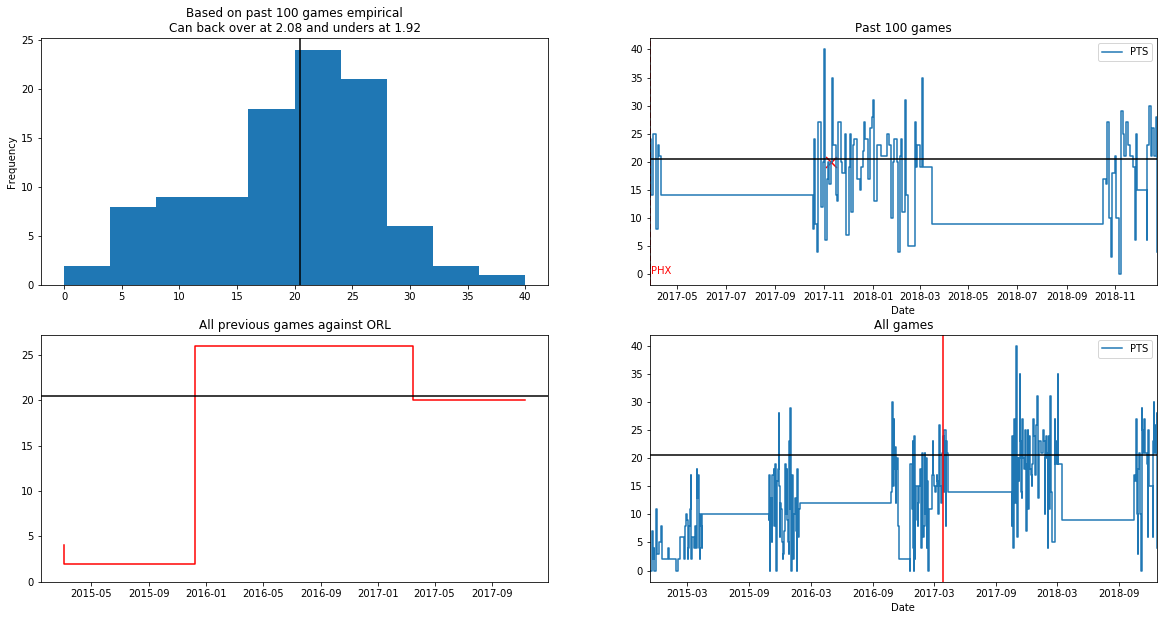

In [12]:
player_name = 'T.J. Warren'
stat = 'PTS'
baseline = 20.5
past_n_games = 100
opp_team = 'ORL'
df = pl_pts_odds_WL(player_name, stat, baseline, past_n_games, opp_team)